In [1]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
batch_size = 20
num_classes = 10
epochs = 50


In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [7]:
x_train = np.reshape(np.array(x_train), (60000, 784))
x_test = np.reshape(np.array(x_test), (10000, 784))
x_train = x_train / 255
x_test = x_test / 255

In [8]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [10]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim)) 
    model.add(Activation('softmax'))
    return model

# def k_model(output_dim,input_dim):
#     model = Sequential() 
#     model.add(Dense(1000, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dense(output_dim))
#     model.add(Activation('softmax'))
#     return model

In [11]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [12]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

### Baseline model 
Got one layer that maps input to 10 classes

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 42s 698us/step - loss: 0.6669 - acc: 0.8352 - val_loss: 0.4208 - val_acc: 0.8901
Epoch 2/15
60000/60000 [==============================] - 40s 660us/step - loss: 0.4105 - acc: 0.8895 - val_loss: 0.3626 - val_acc: 0.9039
Epoch 3/15
60000/60000 [==============================] - 41s 685us/step - loss: 0.3698 - acc: 0.8987 - val_loss: 0.3366 - val_acc: 0.9101
Epoch 4/15
60000/60000 [==============================] - 35s 583us/step - loss: 0.3490 - acc: 0.9033 - val_loss: 0.3235 - val_acc: 0.9113
Epoch 5/15
60000/60000 [==============================] - 43s 717us/step - loss: 0.3356 - acc: 0.9068 - val_loss: 0.3134 - val_acc: 0.9143
Epoch 6/15
60000/60000 [==============================] - 55s 913us/step - loss: 0.3258 - acc: 0.9094 - val_loss: 0.3066 - val_acc: 0.9155
Epoch 7/15
60000/60000 [==============================] - 43s 723us/step - loss: 0.3188 - acc: 0.9114 - val_loss: 0.

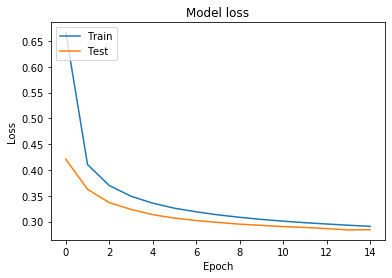

In [15]:
base_model=k_model(10,784)

#base_model=k_model(10,784)
base_model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False),metrics=['accuracy'])
base_model = base_model.fit(x_train, y_train,
              batch_size=20,
              epochs=15,
              verbose=1,
              validation_data=(x_test, y_test))
        
loss(base_model)

## The baseline model gives an accuracy of 91.36% at the end of 50 epochs

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [16]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [17]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [21]:
def local_sgd(n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(k_model(10,784))
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
      
    
    # Training and averaging the weights
    num_epoch = 0 # keeps track of number of epochs
    itr = 0 # keeps track of number of iterations
    c = 0 #keeps track of batch number of the data to process
    
    while (num_epoch != epoch):
        while (True):
            for k in range(n):
                batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                models[k].train_on_batch(batch_x, batch_y)

            c += 1
            itr += 1
            c = c % num_batch

            if (itr % t == 0):
                weights = []
                for l in range(n):
                    weights.append(models[l].get_weights())
                    

                new_weight = weights[0]
                
                # Averaging the weights and assigning it to each model on the nodes
                for l in range(1,n):
                        new_weight = np.array(new_weight) + np.array(weights[l])

         
                for l in range(n):
                    models[l].set_weights(list(np.array(new_weight)/n))
                    
                
                
            if (c == 0):
    
                num_epoch += 1
                loss_tr = models[0].evaluate(train_data[0],train_data[1])
                loss_te = models[0].evaluate(test_data[0],test_data[1])
                print ("Epoch " + str(num_epoch) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
                train_loss.append(loss_tr[0])
                test_loss.append(loss_te[0])
                
                break
    
    
    return (train_loss,test_loss)

### The below 4 cells runs the local SGD model for 2,4,8,16 number of nodes and tunes the learning rate by taking 4 different values for each

In [37]:


local_2_10_001 = local_sgd(2,10,0.001,25,20,(x_train,y_train),(x_test,y_test))

local_2_10_01 = local_sgd(2,10,0.01,25,20,(x_train,y_train),(x_test,y_test))

local_2_10_05 = local_sgd(2,10,0.05,25,20,(x_train,y_train),(x_test,y_test))

local_2_10_1 = local_sgd(2,10,0.1,25,20,(x_train,y_train),(x_test,y_test))



10000/10000 [==============================] - 1s 135us/step
Epoch 1 of 25 : train loss - 1.0044422698338826 : train accuracy - 0.8036333333333333 test loss - 0.980016960811615 test accuracy - 0.8146
10000/10000 [==============================] - 1s 123us/step
Epoch 2 of 25 : train loss - 0.7475557467937469 : train accuracy - 0.8395 test loss - 0.7206396039962768 test accuracy - 0.849
10000/10000 [==============================] - 2s 206us/step
Epoch 3 of 25 : train loss - 0.6389712663332622 : train accuracy - 0.85415 test loss - 0.612104046869278 test accuracy - 0.8642
10000/10000 [==============================] - 1s 145us/step
Epoch 4 of 25 : train loss - 0.5774856105248133 : train accuracy - 0.8625833333333334 test loss - 0.551106837797165 test accuracy - 0.8738
10000/10000 [==============================] - 1s 113us/step
Epoch 5 of 25 : train loss - 0.5371817604621252 : train accuracy - 0.86775 test loss - 0.5113658848047257 test accuracy - 0.8783
10000/10000 [====================

In [38]:

local_4_10_001 = local_sgd(4,10,0.001,25,20,(x_train,y_train),(x_test,y_test))

local_4_10_01 = local_sgd(4,10,0.01,25,20,(x_train,y_train),(x_test,y_test))

local_4_10_05 = local_sgd(4,10,0.05,25,20,(x_train,y_train),(x_test,y_test))

local_4_10_1 = local_sgd(4,10,0.1,25,20,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 2s 190us/step
Epoch 1 of 25 : train loss - 1.004885600821177 : train accuracy - 0.8189 test loss - 0.9829863108634949 test accuracy - 0.827
10000/10000 [==============================] - 3s 266us/step
Epoch 2 of 25 : train loss - 0.7444751012166341 : train accuracy - 0.8457333333333333 test loss - 0.7201678287506104 test accuracy - 0.8552
10000/10000 [==============================] - 4s 378us/step
Epoch 3 of 25 : train loss - 0.6357650417804718 : train accuracy - 0.85775 test loss - 0.6114227568149566 test accuracy - 0.8685
10000/10000 [==============================] - 3s 297us/step
Epoch 4 of 25 : train loss - 0.5745565908908844 : train accuracy - 0.8649833333333333 test loss - 0.550556345653534 test accuracy - 0.8744
10000/10000 [==============================] - 2s 197us/step
Epoch 5 of 25 : train loss - 0.5345477357387542 : train accuracy - 0.8702833333333333 test loss - 0.510957855963707 test accuracy - 0.8794
10000/10000 [=========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 2s 239us/step
Epoch 21 of 25 : train loss - 0.3767464690287908 : train accuracy - 0.8975666666666666 test loss - 0.3580516000032425 test accuracy - 0.9043
10000/10000 [==============================] - 2s 228us/step
Epoch 22 of 25 : train loss - 0.37349770151774087 : train accuracy - 0.89845 test loss - 0.35502756991386414 test accuracy - 0.9049
10000/10000 [==============================] - 2s 219us/step
Epoch 23 of 25 : train loss - 0.37046610010663666 : train accuracy - 0.8990333333333334 test loss - 0.3522149354457855 test accuracy - 0.9053
10000/10000 [==============================] - 2s 191us/step
Epoch 24 of 25 : train loss - 0.3676281387190024 : train accuracy - 0.8999 test loss - 0.34959051213264464 test accuracy - 0.9058
10000/10000 [==============================] - 3s 258us/step
Epoch 25 of 25 : train loss - 0.36496371445854503 : train accuracy - 0.9005833333333333 test loss - 0.34713452348709106 test accuracy - 0.9063
10000/1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 2s 204us/step
Epoch 16 of 25 : train loss - 0.2435614100853602 : train accuracy - 0.9330833333333334 test loss - 0.26616695196032525 test accuracy - 0.9238
10000/10000 [==============================] - 3s 281us/step
Epoch 17 of 25 : train loss - 0.2427560776581367 : train accuracy - 0.9333833333333333 test loss - 0.26619901134967805 test accuracy - 0.9236
10000/10000 [==============================] - 2s 174us/step
Epoch 18 of 25 : train loss - 0.2420071948846181 : train accuracy - 0.9336 test loss - 0.2662493150174618 test accuracy - 0.9239
10000/10000 [==============================] - 2s 152us/step
Epoch 19 of 25 : train loss - 0.24130724981427193 : train accuracy - 0.9337666666666666 test loss - 0.26631778509318826 test accuracy - 0.924
10000/10000 [==============================] - 2s 185us/step
Epoch 20 of 25 : train loss - 0.24065007651050885 : train accuracy - 0.9337666666666666 test loss - 0.2663994136363268 test accuracy - 0.924

In [ ]:

local_8_10_001 = local_sgd(8,10,0.001,25,20,(x_train,y_train),(x_test,y_test))

local_8_10_01 = local_sgd(8,10,0.01,25,20,(x_train,y_train),(x_test,y_test))

local_8_10_05 = local_sgd(8,10,0.05,25,20,(x_train,y_train),(x_test,y_test))

local_8_10_1 = local_sgd(8,10,0.1,25,20,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 131us/step
Epoch 1 of 25 : train loss - 1.0029100640296935 : train accuracy - 0.8169166666666666 test loss - 0.9805809230804443 test accuracy - 0.8289
10000/10000 [==============================] - 2s 205us/step
Epoch 2 of 25 : train loss - 0.7433530166467031 : train accuracy - 0.8436333333333333 test loss - 0.7186228517532348 test accuracy - 0.8547
10000/10000 [==============================] - 2s 194us/step
Epoch 3 of 25 : train loss - 0.6352474646647771 : train accuracy - 0.85645 test loss - 0.6104450978279113 test accuracy - 0.8678


In [ ]:

local_16_10_001 = local_sgd(16,10,0.001,25,20,(x_train,y_train),(x_test,y_test))

local_16_10_01 = local_sgd(16,10,0.01,25,20,(x_train,y_train),(x_test,y_test))

local_16_10_05 = local_sgd(16,10,0.05,25,20,(x_train,y_train),(x_test,y_test))

local_16_10_1 = local_sgd(16,10,0.1,25,20,(x_train,y_train),(x_test,y_test))

In [44]:
# Function to show the loss plot of training and validation set
def combined_loss(losses,description):
    for i in losses :
        plt.plot(i[0])
        plt.title('Train loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()
    
    for i in losses :
        plt.plot(i[1])
        plt.title('Test loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()

### Train test loss for node = 2

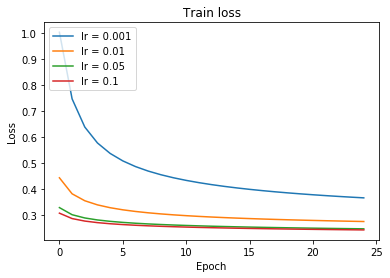

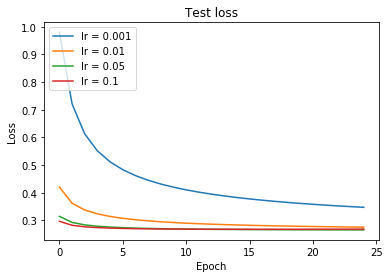

In [45]:
losses_2 = [local_2_10_001,local_2_10_01,local_2_10_05,local_2_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for node = 4

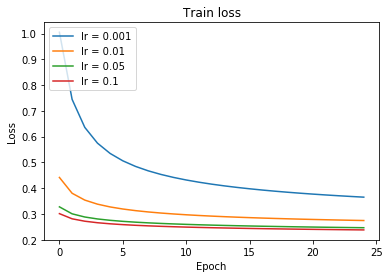

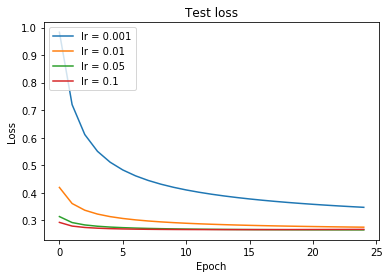

In [46]:
losses_2 = [local_4_10_001,local_4_10_01,local_4_10_05,local_4_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train Test loss for nodes = 8

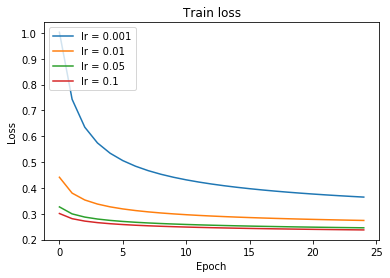

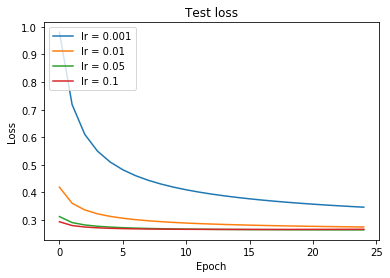

In [47]:
losses_2 = [local_8_10_001,local_8_10_01,local_8_10_05,local_8_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for nodes = 16

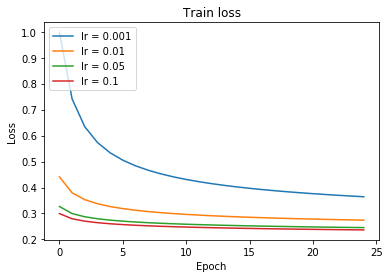

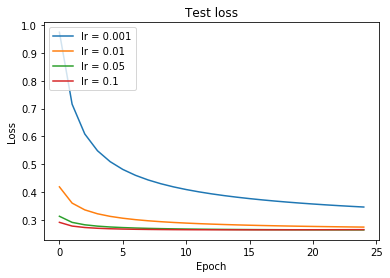

In [48]:
losses_2 = [local_16_10_001,local_16_10_01,local_16_10_05,local_16_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for lr = 0.1 and nodes = 2,4,8,16

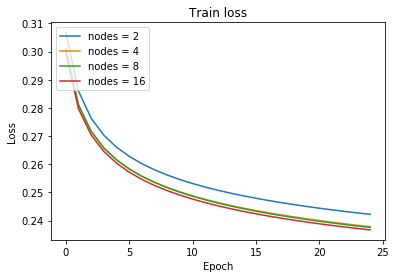

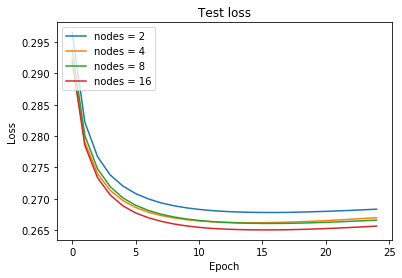

In [49]:
losses_2 = [local_2_10_1,local_4_10_1,local_8_10_1,local_16_10_1]
desc = ['nodes = 2','nodes = 4','nodes = 8','nodes = 16']
combined_loss(losses_2,desc)

### The convergence does not depend on number of nodes

In [36]:

local_8_16_01 = local_sgd(8,16,0.1,50,128,(x_train,y_train),(x_test,y_test))

local_8_8_01 = local_sgd(8,8,0.1,50,128,(x_train,y_train),(x_test,y_test))

local_8_4_01 = local_sgd(8,4,0.1,50,128,(x_train,y_train),(x_test,y_test))

local_8_2_01 = local_sgd(8,2,0.1,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 2s 166us/step
Epoch 1 of 50 : train loss - 0.39844022920926414 : train accuracy - 0.8931666666666667 test loss - 0.3784469843506813 test accuracy - 0.9004
10000/10000 [==============================] - 2s 211us/step
Epoch 2 of 50 : train loss - 0.35069441570838294 : train accuracy - 0.9030666666666667 test loss - 0.3343164290547371 test accuracy - 0.9088
10000/10000 [==============================] - 2s 211us/step
Epoch 3 of 50 : train loss - 0.32961572636564573 : train accuracy - 0.9083333333333333 test loss - 0.3158205985546112 test accuracy - 0.9136
10000/10000 [==============================] - 2s 206us/step
Epoch 4 of 50 : train loss - 0.31693364827434223 : train accuracy - 0.9117 test loss - 0.30518022366166114 test accuracy - 0.9164
10000/10000 [==============================] - 2s 221us/step
Epoch 5 of 50 : train loss - 0.30819882263143855 : train accuracy - 0.9141833333333333 test loss - 0.2981679040312767 test accuracy - 0.917
10

KeyboardInterrupt: 

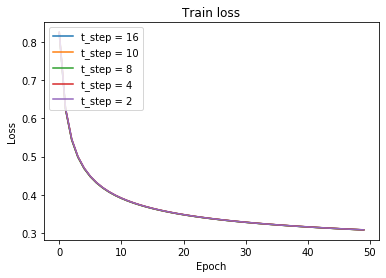

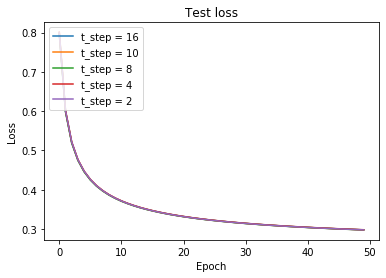

In [39]:
losses_time = [local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

### Convergence does not depend on averaging time step

In [ ]:
model_parallel = k_model(10,784)
#local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))
local_8_500_01 = local_sgd(model_parallel,8,500,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
model_parallel = k_model(10,784)
#local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))
local_8_1000_01 = local_sgd(model_parallel,8,1000,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
# One Shot Averaging : Minor tweaking in the previous function 

def local_sgd_oneshot_avg(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []

        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break

            # Obtaining the weights from each model
            '''for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)'''


        # Evalutaing the losses (train and test and appending it to the list)
        if (i != epoch - 1) :
            loss_tr = models[0].evaluate(train_data[0],train_data[1])
            loss_te = models[0].evaluate(test_data[0],test_data[1])
            print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
            train_loss.append(loss_tr[0])
            test_loss.append(loss_te[0])
            
    for l in range(len(models)):
        weights.append(models[l].layers[0].get_weights())
        new_weight = weights[0]
            
    # Averaging the weights and assigning it to each model on the nodes
    for l in range(1,n):
        if l !=n-1:
            new_weight = [j+k for j,k in zip(new_weight,weights[l])]
        else:
            new_weight = [(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
    for l in range(len(models)):
            models[l].set_weights(new_weight)
            

    loss_tr = models[0].evaluate(train_data[0],train_data[1])
    loss_te = models[0].evaluate(test_data[0],test_data[1])
    print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
    train_loss.append(loss_tr[0])
    test_loss.append(loss_te[0])

    
    return (train_loss,test_loss)

In [ ]:
model_parallel = k_model(10,784)
local_oneshot_8_16_01 = local_sgd_oneshot_avg(model_parallel,8,16,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
# Tuning the learning rate for time steps = 2,4,8,16,100

# Time Step = 2
model_parallel = k_model(10,784)
local_8_2_001 = local_sgd(model_parallel,8,2,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_05 = local_sgd(model_parallel,8,2,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_1 = local_sgd(model_parallel,8,2,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_5 = local_sgd(model_parallel,8,2,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 4
model_parallel = k_model(10,784)
local_8_4_001 = local_sgd(model_parallel,8,4,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_05 = local_sgd(model_parallel,8,4,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_1 = local_sgd(model_parallel,8,4,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_5 = local_sgd(model_parallel,8,4,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 8
model_parallel = k_model(10,784)
local_8_8_001 = local_sgd(model_parallel,8,8,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_05 = local_sgd(model_parallel,8,8,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_1 = local_sgd(model_parallel,8,8,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_5 = local_sgd(model_parallel,8,8,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 16
model_parallel = k_model(10,784)
local_8_16_001 = local_sgd(model_parallel,8,16,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_05 = local_sgd(model_parallel,8,16,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_1 = local_sgd(model_parallel,8,16,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_5 = local_sgd(model_parallel,8,16,0.5,50,128,(x_train,y_train),(x_test,y_test))




In [3]:
# Plotting losses for t = 2
losses_8_t = [local_8_2_001,local_8_2_05,local_8_2_1,local_8_2_5,local_8_2_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_t,desc)

NameError: name 'local_8_2_001' is not defined

In [ ]:
# Plotting losses for t = 4
losses_8_4 = [local_8_4_001,local_8_4_05,local_8_4_1,local_8_4_5,local_8_4_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_4,desc)

In [ ]:
# Plotting losses for t = 8
losses_8_8 = [local_8_8_001,local_8_8_05,local_8_8_1,local_8_8_5,local_8_8_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_8,desc)

In [ ]:
# Plotting losses for t = 16
losses_8_16 = [local_8_16_001,local_8_16_05,local_8_16_1,local_8_16_5,local_8_16_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_16,desc)

In [ ]:

# Plotting the plots for different timesteps

losses_opt = [local_8_2_1,local_8_4_1,local_8_8_1,local_8_16_01,local_oneshot_8_16_01]
desc = ['time step = 2','time step = 4','time step = 8','time step = 16','one shot averaging']
combined_loss(losses_opt,desc)

In [ ]:
model_parallel = k_model(10,784)
local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
losses_time = [local_8_100_01,local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 100','t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

In [ ]:
def elastic_avg_sgd(input_dim,output_dim,n,t,alpha,rho,epoch,batch_size,train_data,test_data): 
    '''
    This function performs elastic averaging sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       alpha : learning rate a float value
       rho : averaging step for the center variable
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(k_model(output_dim,input_dim))
    
    # The model at the central node 
    central_model = k_model(output_dim,input_dim)
    central_model.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
    
    
    # Calculating the center models
    # Taking the first center model as the average of all the weights from the individual models on the nodes
    weights = []
    for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

    new_weight = weights[0]
            
    # Averaging the weights and assigning it to each model on the nodes
    for l in range(1,n):
        if l !=n-1:
            new_weight = [j+k for j,k in zip(new_weight,weights[l])]
        else:
            new_weight = [(j+k)/n for j,k in zip(new_weight,weights[l])]
    
    # Assigning the weights to the central model
    central_model.set_weights(new_weight)
            
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break
            
            else :
                # Obtaining the weights from each model
                weights = []
                for l in range(len(models)):
                    weights.append(models[l].layers[0].get_weights())

                # Updating the weights of the models on every node using previous central node value
                central_weight = central_model.layers[0].get_weights()
                for l in range(0,n):
                    new_weight = list(np.array(weights[l]) - rho * (np.array(weights[l]) - np.array(central_weight)))
                    models[l].set_weights(new_weight)

                # Updating the weights on the central node
                delta = list(np.array(weights[0]) - np.array(central_weight))

                for l in range(1,n):
                    temp = list(np.array(weights[l]) - np.array(central_weight))
                    delta = list(np.array(delta) + np.array(temp))

                central_weight = list(np.array(central_weight) + rho * np.array(delta))
                central_model.layers[0].set_weights(central_weight)       
            


        # Evalutaing the losses (train and test and appending it to the list)
        loss_tr = central_model.evaluate(train_data[0],train_data[1])
        loss_te = central_model.evaluate(test_data[0],test_data[1])
        print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
        train_loss.append(loss_tr[0])
        test_loss.append(loss_te[0])
    
    return (train_loss,test_loss)

In [ ]:
elastic_2_10_001 = elastic_avg_sgd(784,10,2,10,0.01,0.1,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
1+1

In [41]:
1+1

2

In [43]:
1

1